In [72]:
import csv
import os

import cv2
import matplotlib.animation as animation
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

from scipy.spatial import cKDTree

from dataManager import DataManager
from maskPredictor import MaskPredictor


def datagen(video_path,nn_weights_path, batch_size=1, output_length=30):
    """Data generator: takes video and weights path and produce a tuple: masks and source """
    data_mngr = DataManager(video_path)
    frame_generator = data_mngr.get_frames_gen(batch_size=batch_size,
                                               num=30*output_length*60)
    nn_model = MaskPredictor(nn_weights_path)
    masks_generator = nn_model.get_mask_generator(frame_generator, th=0.8)

    bubbles_max = 200

    feature_params = dict(maxCorners=bubbles_max, qualityLevel=0.3, minDistance=7, blockSize=7)
    # Parameters for Lucas Kanade optical flow
    lk_params = dict(
        winSize=(15, 15),
        maxLevel=2,
        criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03),
    )
    # Create random colors
    color = np.random.randint(0, 255, (300, 3))

    mask, frame, source = next(masks_generator)
 # Create a mask image for drawing purposes


    p0 = cv2.goodFeaturesToTrack(mask, mask=None, **feature_params)

    old_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    stored_points = []

    for i, (mask, frame, source) in tqdm(enumerate(masks_generator)):
        # # contours
        of_mask = np.zeros_like(frame)
        contours = source.copy()
        mask = cv2.resize(mask, (contours.shape[1], contours.shape[0])).astype(np.uint8)
        # mask = cv2.threshold(np.uint8(mask[:,:]*255), 210, 255, cv2.THRESH_BINARY)[1]
        kernel = np.ones((9, 9), np.uint8)
        mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
        cnts, hierarchy = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        cv2.drawContours(contours, cnts, -1, (0, 255, 0), 2)

        ## LK Optical flow
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        p1, st, err = cv2.calcOpticalFlowPyrLK(
            old_gray, gray, p0, None, **lk_params
        )
        # Select good points
        good_new = p1[st == 1]
        good_old = p0[st == 1]
        if len(stored_points)<10:
            stored_points.append(list(zip(good_new, good_old)))
        else:
            stored_points = stored_points[1:]
            stored_points.append(list(zip(good_new, good_old)))
        # Draw the tracks
        vectors = None
        for n, j in enumerate(stored_points):
            if n == len(stored_points)-1:
                vectors = np.array(list(j))
            for i, (new, old) in enumerate(j):
                a, b = new.ravel()
                c, d = old.ravel()
                of_mask = cv2.line(of_mask, (int(a), int(b)), (int(c), int(d)), color[i].tolist(), 1)
                of_mask = cv2.circle(of_mask, (int(a), int(b)), 2, color[i].tolist(), -1)

        dx = vectors[:,1, 0]-vectors[:,0, 0]
        dy = vectors[:,1, 1]-vectors[:,0, 1]

        of_mask = cv2.line(of_mask, (int(25), int(25)), (int(25+dx.mean()), int(25+dy.mean())), (255, 255, 255), 1)


        # Display the
        # show(frame, mask, cv2.add(frame, mask))

        of = cv2.add(frame, of_mask)

        # Update the previous frame and previous points

        old_gray = gray.copy()
        p0 = good_new.reshape(-1, 1, 2)

        new_points = cv2.goodFeaturesToTrack(mask, mask=None, **feature_params)
        p_temp = []
        for p_new in new_points:
            for p_stored in p0:
                if abs(p_new[0][0]-p_stored[0][0])<30 and abs(p_new[0][1]-p_stored[0][1])<30:
                    break
            else:
                p_temp.append(p_new)
        p0 = np.concatenate([p0,np.array(p_temp).reshape(-1, 1, 2)], axis=0)
        print(len(p0))
        # print(np.array(p_temp).reshape(-1, 1, 2).shape)
        data = {'orig': source,
                'mask': mask,
                'contours':  contours,
                'of':of
                }
        yield data

def visualizer(generator, savepath, output_length=0.5, fps=15, bitrate=1800):
    fig = plt.figure(constrained_layout=True, figsize=(18, 12))
    gs = fig.add_gridspec(4, 4)
    ax_orig = fig.add_subplot(gs[0:2, :2])
    ax_orig.set_title('Исходное изображение', fontsize=12)
    ax_masks = fig.add_subplot(gs[2:, 0:2])
    ax_masks.set_title('Маска', fontsize=12)
    ax_contours = fig.add_subplot(gs[:2, 2:])
    ax_contours.set_title('Рассчитанные контуры', fontsize=12)
    ax_of = fig.add_subplot(gs[2:, 2:])
    ax_of.set_title('Поток', fontsize=12)

    ax_contours.axis('off')
    ax_orig.axis('off')
    ax_masks.axis('off')
    ax_of.axis('off')


    def updateData(data):
        keys = ['orig', 'mask',  'contours', 'of']
        orig, mask,   contours, of = [data[key] for key in keys]
        # original
        ax_orig.clear()
        ax_orig.set_title('Исходное изображение', fontsize=12)
        ax_orig.imshow(orig, aspect='auto')
        ax_orig.axis('off')

        # masks
        ax_masks.clear()
        ax_masks.set_title('Маска', fontsize=12)
        ax_masks.imshow(mask, cmap='gray', aspect='auto')
        ax_masks.axis('off')

        # # contours
        ax_contours.clear()
        ax_contours.set_title('Рассчитанные контуры', fontsize=12)
        ax_contours.imshow(contours, aspect='auto')
        ax_contours.axis('off')

   # # contours
        ax_of.clear()
        ax_of.set_title('Поток', fontsize=12)
        ax_of.imshow(of, aspect='auto')
        ax_of.axis('off')
    simulation = animation.FuncAnimation(fig, updateData, frames=generator, save_count=30*output_length*60)

    writer = animation.writers['ffmpeg'](fps=fps, bitrate=10000)
    simulation.save(savepath, writer=writer)


0it [00:00, ?it/s]

355


1it [00:00,  1.05it/s]

361


2it [00:01,  1.17it/s]

363


3it [00:02,  1.31it/s]

353


4it [00:03,  1.40it/s]

352


5it [00:03,  1.42it/s]

338


6it [00:04,  1.36it/s]

335


7it [00:05,  1.32it/s]

340


8it [00:06,  1.36it/s]

341


9it [00:06,  1.36it/s]

342


10it [00:07,  1.38it/s]

339


11it [00:08,  1.38it/s]

330


12it [00:08,  1.37it/s]

327


13it [00:09,  1.39it/s]

337


14it [00:10,  1.39it/s]

325


15it [00:11,  1.34it/s]

327


16it [00:11,  1.33it/s]

330


17it [00:13,  1.14it/s]

330


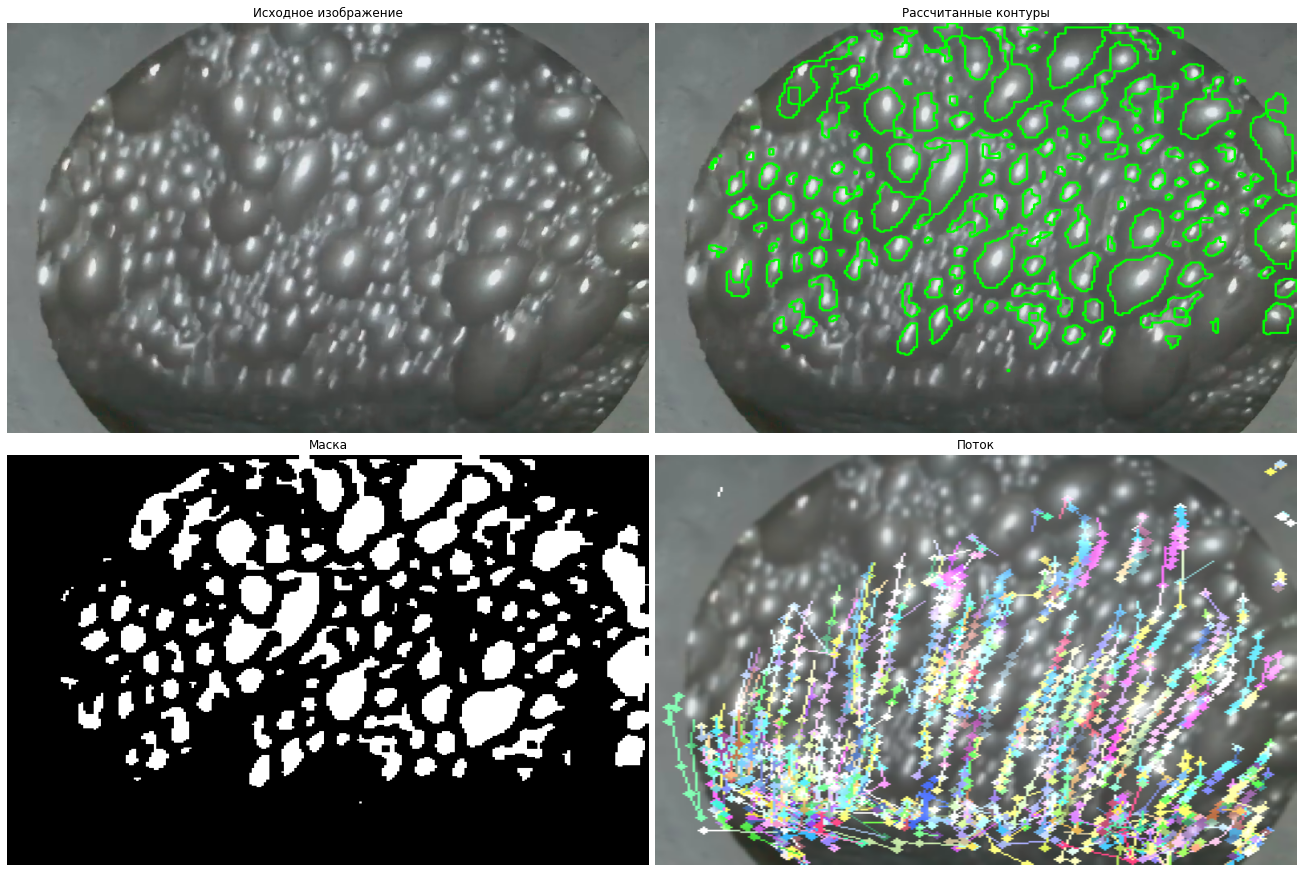

In [73]:
if not os.path.exists('./results'):
    os.makedirs('./results')

if not os.path.exists('./weights'):
    os.makedirs('./weights')

if not os.path.exists('../data'):
    os.makedirs('../data')

generator = datagen('data/90_2_3.mp4', 'weights/unet_weights.pt', batch_size=1)
visualizer(generator, './results/visualization.mp4', fps=15, output_length=0.01)